# **Continuación Práctica Final de Deep Learning**

Debido al costo computacional y que tanto con la CPU como T4 GPU, ha sido imposible integrar esta parte del codigo en el notebook principal.

Para esta continuación de la práctica, se va a dar un enfoque igual que el anterior pero utilizando modelos preentrenados como VGG16 y ResNet50 para realizar una extracción rápida de características.

## **Importación librerías y carga de datos**

In [8]:
import numpy as np
import pandas as pd
import os
import itertools
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import cv2
import glob
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input  # Ajusta según el modelo

from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten,Dense,Dropout, BatchNormalization
from google.colab import files
import warnings
warnings.filterwarnings("ignore")

print("Load Models")

Load Models


In [79]:
!pip install kaggle

In [80]:
# Despliega el cuadro de diálogo para subir archivos
uploaded = files.upload()

# Listar los archivos subidos (opcional)
for file_name in uploaded.keys():
    print(f'Archivo subido: {file_name}')

Saving kaggle.json to kaggle (1).json
Archivo subido: kaggle (1).json


In [81]:
# Crea la carpeta .kaggle y mueve el archivo kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Cambia los permisos para el archivo kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [82]:
# Instala la Kaggle CLI
!pip install -q kaggle

In [83]:
# Descarga el dataset utilizando el identificador del nuevo dataset
!kaggle datasets download -d kausthubkannan/5-flower-types-classification-dataset

# Descomprimir el archivo descargado
!unzip -q 5-flower-types-classification-dataset.zip -d /content/flower_dataset

Dataset URL: https://www.kaggle.com/datasets/kausthubkannan/5-flower-types-classification-dataset
License(s): other
5-flower-types-classification-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace /content/flower_dataset/flower_images/Lilly/00048a5c76.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## **Exploración y visualización del conjunto de datos**

In [9]:

# Definir la ruta base donde se encuentran los archivos de flores
base_dir = '/content/flower_dataset/flower_images'



In [10]:
def load_images_from_folder(folder, label):
    images = []
    labels = []  # Prepare a list to store the labels of the images
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_COLOR)
        if img is not None:
            img = cv2.resize(img, (224, 224))  # Resize images to uniform size
            images.append(img)
            labels.append(label)
    return images, labels

# Paths to your datasets
Lilly_path = '/content/flower_dataset/flower_images/Lilly'
Lotus_path = '/content/flower_dataset/flower_images/Lotus'
Orchid_path = '/content/flower_dataset/flower_images/Orchid'
Sunf_path = '/content/flower_dataset/flower_images/Sunflower'
Tulip_path = '/content/flower_dataset/flower_images/Tulip'


In [11]:
pd.DataFrame(os.listdir(base_dir),columns=['Files_Name'])

,Files_Name
0,Tulip
1,Lotus
2,Sunflower
3,Lilly
4,Orchid


In [13]:
# Crear un DataFrame con los nombres de los archivos
files = [i for i in glob.glob(base_dir + "//*//*")]
np.random.shuffle(files)
labels = [os.path.dirname(i).split("/")[-1] for i in files]
data = zip(files, labels)
dataframe = pd.DataFrame(data, columns=["Image", "Label"])

# Mostrar el DataFrame
dataframe

,Image,Label
0,/content/flower_dataset/flower_images/Lotus/6c...,Lotus
1,/content/flower_dataset/flower_images/Lotus/3f...,Lotus
2,/content/flower_dataset/flower_images/Orchid/d...,Orchid
3,/content/flower_dataset/flower_images/Lotus/b5...,Lotus
4,/content/flower_dataset/flower_images/Sunflowe...,Sunflower
...,...,...
4995,/content/flower_dataset/flower_images/Sunflowe...,Sunflower
4996,/content/flower_dataset/flower_images/Lotus/b8...,Lotus
4997,/content/flower_dataset/flower_images/Sunflowe...,Sunflower
4998,/content/flower_dataset/flower_images/Lilly/ee...,Lilly


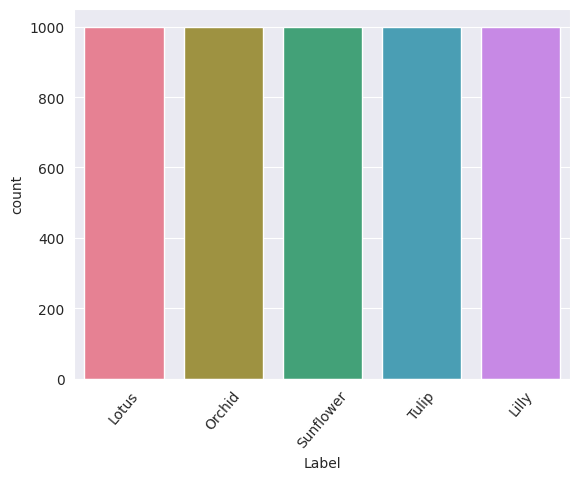

In [14]:
# Define una paleta de colores
palette = sns.color_palette("husl", len(dataframe["Label"].unique()))

# Crea el gráfico de barras con la paleta de colores
sns.countplot(x=dataframe["Label"], palette=palette)

# Rota las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=50)

# Muestra el gráfico
plt.show()

Como podemos observar encontramos 1000 imágenes para cada especie de flor de nuestro conjunto de datos

In [15]:

# Load images and labels for each flower category
lilly_images, lilly_labels = load_images_from_folder(Lilly_path, 'Lilly')
lotus_images, lotus_labels = load_images_from_folder(Lotus_path, 'Lotus')
orchid_images, orchid_labels = load_images_from_folder(Orchid_path, 'Orchid')
sunf_images, sunf_labels = load_images_from_folder(Sunf_path, 'Sunflower')
tulip_images, tulip_labels = load_images_from_folder(Tulip_path, 'Tulip')

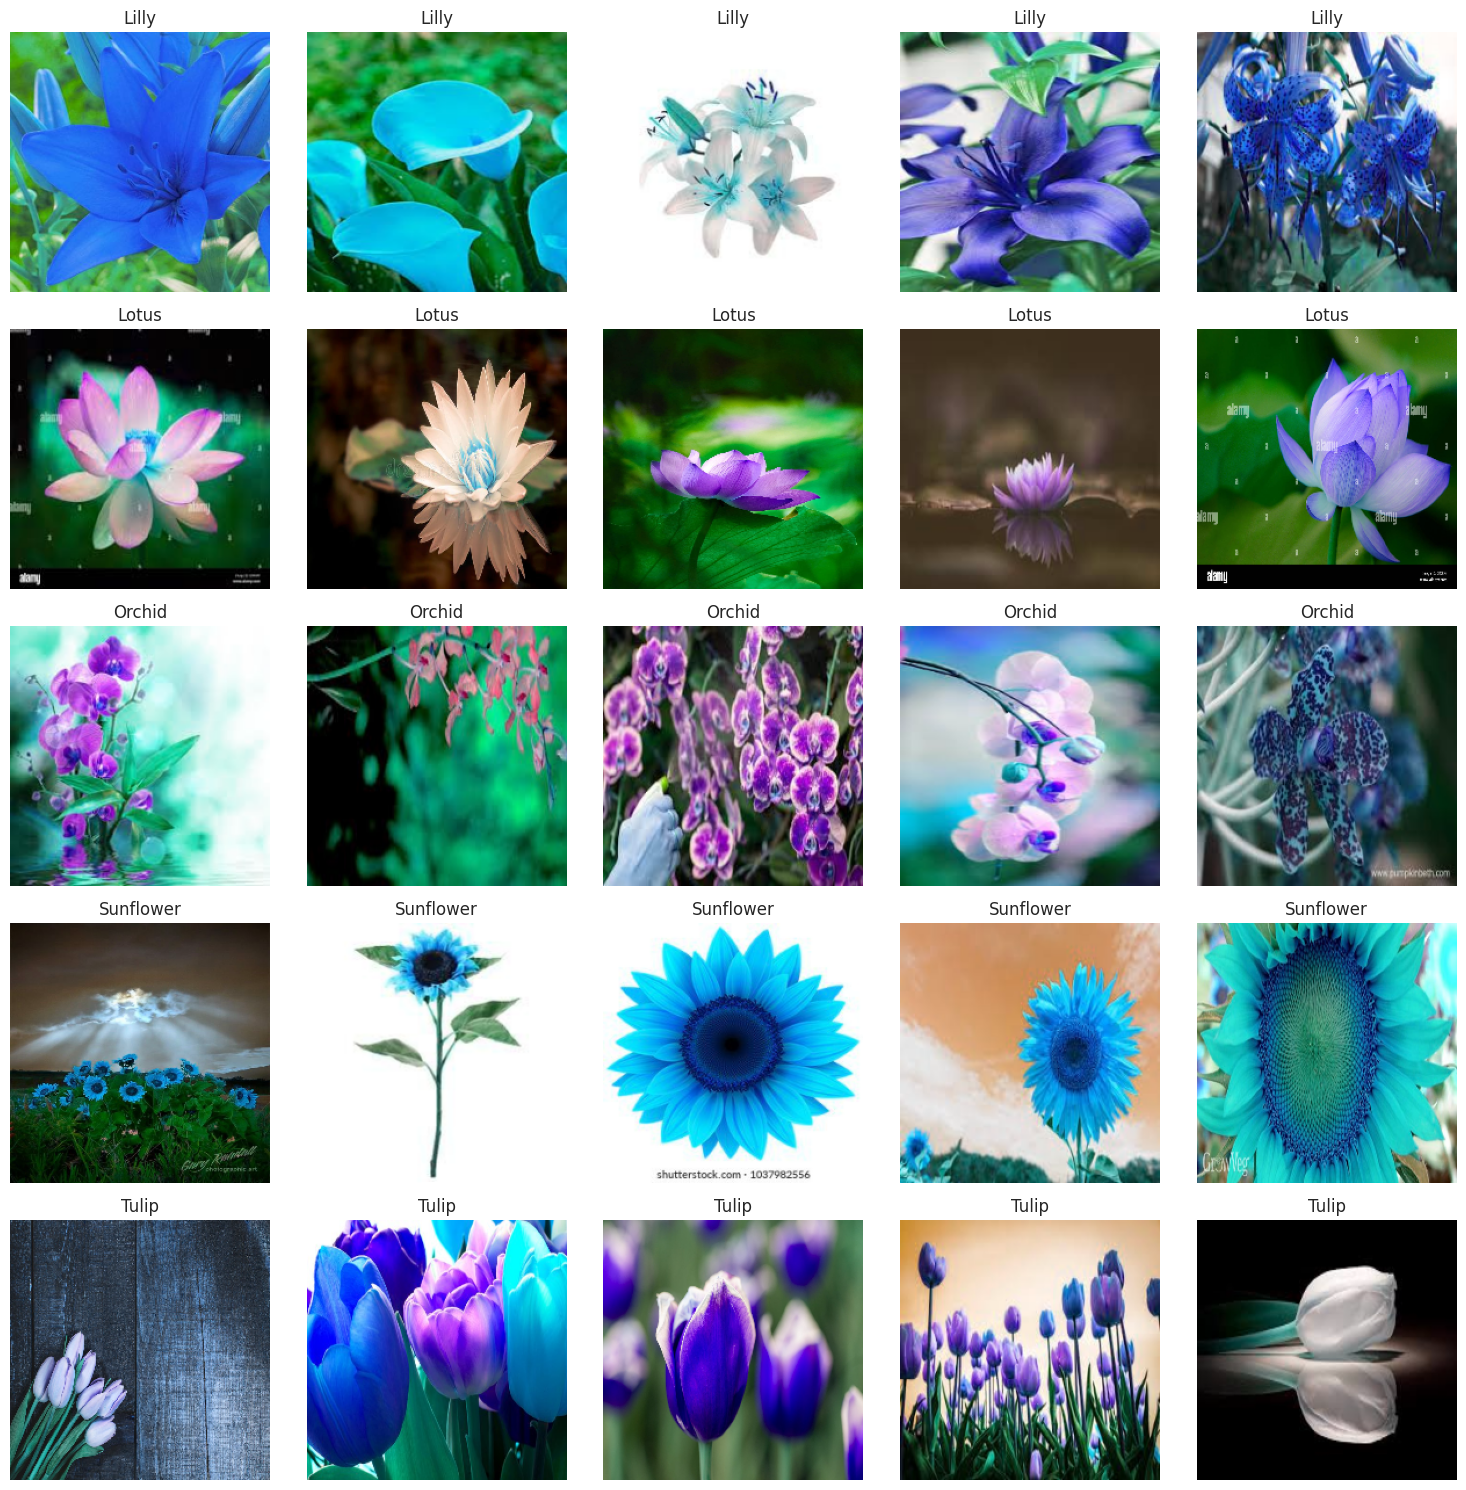

In [16]:

# Display images
fig, axes = plt.subplots(5, 5, figsize=(15, 15))  # 5 rows of images, 5 columns

# Ensure that the axes object is a 2D array
if len(lilly_images) < 5 or len(lotus_images) < 5 or len(orchid_images) < 5 or len(sunf_images) < 5 or len(tulip_images) < 5:
    raise ValueError("Not enough images loaded for displaying.")

# Display Lilly images
for i in range(5):
    ax = axes[0, i]  # Select the subplot
    ax.imshow(lilly_images[i], cmap='gray')
    ax.set_title('Lilly')
    ax.axis('off')

# Display Lotus images
for i in range(5):
    ax = axes[1, i]  # Select the subplot
    ax.imshow(lotus_images[i], cmap='gray')
    ax.set_title('Lotus')
    ax.axis('off')

# Display Orchid images
for i in range(5):
    ax = axes[2, i]  # Select the subplot
    ax.imshow(orchid_images[i], cmap='gray')
    ax.set_title('Orchid')
    ax.axis('off')

# Display Sunflower images
for i in range(5):
    ax = axes[3, i]  # Select the subplot
    ax.imshow(sunf_images[i], cmap='gray')
    ax.set_title('Sunflower')
    ax.axis('off')

# Display Tulip images
for i in range(5):
    ax = axes[4, i]  # Select the subplot
    ax.imshow(tulip_images[i], cmap='gray')
    ax.set_title('Tulip')
    ax.axis('off')

plt.tight_layout()
plt.show()


In [18]:

data = []
labels = []
label_names = os.listdir(base_dir)
for label in label_names:
    imgs, lbls = load_images_from_folder(os.path.join(base_dir, label), label)
    data.extend(imgs)
    labels.extend(lbls)

# Convert to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Label encoding
le = LabelEncoder()
labels = le.fit_transform(labels)


# Split dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

## **MODELOS PREENTRENADOS**

### **PRIMERA FORMA: Extracción rápida de características sin aumento de datos**

El modelo VGG16 fue diseñado por el Visual Geometry Group (VGG) de la Universidad de Oxford y se entrenó con imágenes del dataset ImageNet, que contiene millones de imágenes etiquetadas en 1000 categorías. El tamaño de las imágenes de entrada 224x224 píxeles se estableció como un estándar para este modelo.

In [21]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(len(label_names), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [22]:
# Train the model
history= model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
125/125 [==============================] - 70s 417ms/step - loss: 4.0056 - accuracy: 0.1988 - val_loss: 1.6098 - val_accuracy: 0.1930
Epoch 2/10
125/125 [==============================] - 52s 417ms/step - loss: 1.6825 - accuracy: 0.2205 - val_loss: 1.6104 - val_accuracy: 0.1940
Epoch 3/10
125/125 [==============================] - 52s 414ms/step - loss: 1.6583 - accuracy: 0.2010 - val_loss: 1.6103 - val_accuracy: 0.1970
Epoch 4/10
125/125 [==============================] - 53s 426ms/step - loss: 1.6075 - accuracy: 0.2220 - val_loss: 1.6091 - val_accuracy: 0.2040
Epoch 5/10
125/125 [==============================] - 52s 414ms/step - loss: 1.6097 - accuracy: 0.2023 - val_loss: 1.6099 - val_accuracy: 0.1920
Epoch 6/10
125/125 [==============================] - 53s 423ms/step - loss: 1.6096 - accuracy: 0.2013 - val_loss: 1.6100 - val_accuracy: 0.1920
Epoch 7/10
125/125 [==============================] - 53s 423ms/step - loss: 1.6095 - accuracy: 0.2015 - val_loss: 1.6102 - val_ac


El modelo muestra escasa mejora en la precisión y la pérdida tanto en el conjunto de entrenamiento como en el de validación a lo largo de las épocas. La precisión se mantiene baja, alrededor del 20%, y la pérdida se mantiene alta. Esto puede indicar varios problemas, como sobreajuste, una arquitectura de modelo inadecuada para el problema, o la necesidad de ajustar hiperparámetros.

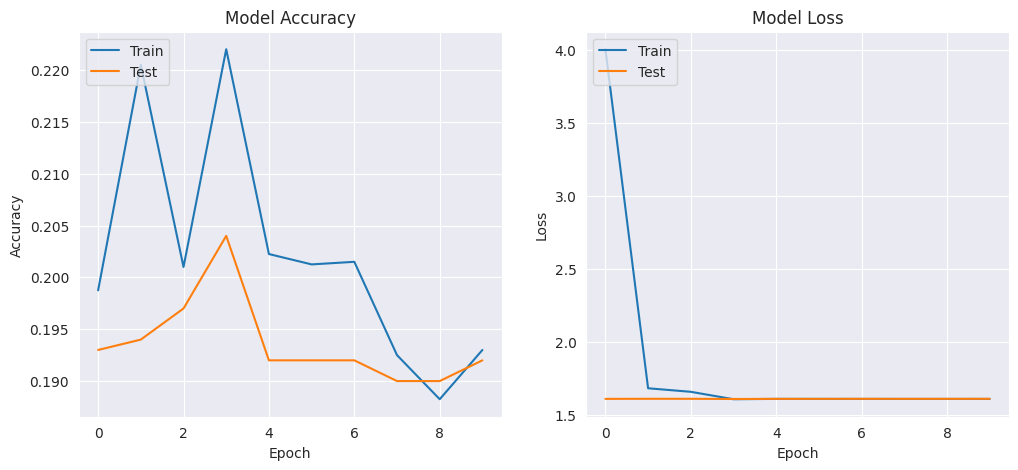

In [23]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

## **SEGUNDA FORMA: Utilización de Congelación de Capas y de otro tipo de modelo preentrenado**

El modelo base utilizado es ResNet50, preentrenado con pesos de imagenet, excluyendo la capa superior (include_top=False).

A diferencia de la otra forma, en esta, la base convolucional del modelo se congela (trainable=False) para no actualizar sus pesos durante el entrenamiento.


Congelar la base convolucional de un modelo preentrenado como ResNet50 permite aprovechar las características robustas ya aprendidas, mejorando la eficiencia del entrenamiento, evitando el sobreajuste y facilitando la transferencia de aprendizaje, lo que resulta en un modelo que generaliza mejor a nuevos datos.

### MODELO 1

In [24]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the convolutional base

model2 = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(len(label_names), activation='softmax')
])

# Compile the model
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 [==============================] - 1s 0us/step


In [25]:
# Train the model
history2= model2.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
125/125 [==============================] - 24s 142ms/step - loss: 3.7344 - accuracy: 0.7920 - val_loss: 0.5583 - val_accuracy: 0.8960
Epoch 2/10
125/125 [==============================] - 17s 134ms/step - loss: 0.1554 - accuracy: 0.9663 - val_loss: 0.4566 - val_accuracy: 0.9050
Epoch 3/10
125/125 [==============================] - 16s 127ms/step - loss: 0.0406 - accuracy: 0.9887 - val_loss: 0.5049 - val_accuracy: 0.9280
Epoch 4/10
125/125 [==============================] - 18s 142ms/step - loss: 0.0261 - accuracy: 0.9960 - val_loss: 0.5634 - val_accuracy: 0.9390
Epoch 5/10
125/125 [==============================] - 15s 122ms/step - loss: 0.0481 - accuracy: 0.9945 - val_loss: 0.6112 - val_accuracy: 0.9150
Epoch 6/10
125/125 [==============================] - 16s 124ms/step - loss: 0.0147 - accuracy: 0.9967 - val_loss: 0.5965 - val_accuracy: 0.9330
Epoch 7/10
125/125 [==============================] - 18s 143ms/step - loss: 0.0192 - accuracy: 0.9980 - val_loss: 0.5813 - val_ac

El modelo ResNet50 muestra una mejora significativa en comparación con el modelo VGG16. La precisión de entrenamiento rápidamente alcanza valores cercanos al 100%, y la precisión de validación se mantiene constantemente alta, alrededor del 93%. Aunque la pérdida de validación no disminuye tanto como la pérdida de entrenamiento, los resultados indican una buena capacidad de generalización del modelo.

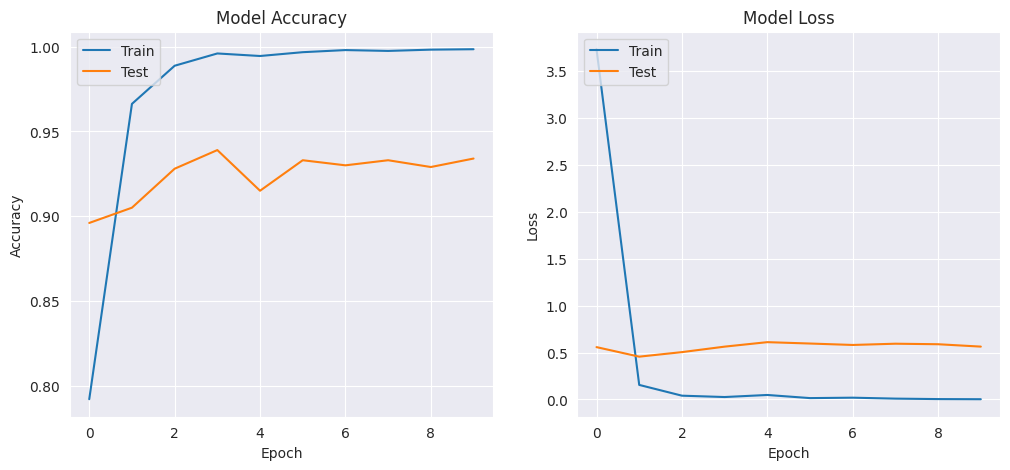

In [26]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

In [27]:
# Evaluar el modelo en el conjunto de datos de prueba
test_loss, test_accuracy = model2.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


32/32 [==============================] - 3s 94ms/step - loss: 0.5637 - accuracy: 0.9340
Test Loss: 0.5637
Test Accuracy: 0.9340


### MODELO 2

En este caso, se tomará de referencia el modelo anterior y se le añadirá Early Stopping lo cual permitirá obtener el mejor modelo, junto con capas Flaten y Dropout con regularizador l2 para evitar el sobreajuste.

In [31]:
from tensorflow.keras import layers, models, regularizers, callbacks
base_model.trainable = False  # Freeze the convolutional base

model3 = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(len(label_names), activation='softmax')
])

# Compile the model
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history3 = model3.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/30
125/125 [==============================] - 22s 145ms/step - loss: 4.1333 - accuracy: 0.6445 - val_loss: 1.3963 - val_accuracy: 0.8000
Epoch 2/30
125/125 [==============================] - 17s 134ms/step - loss: 1.4250 - accuracy: 0.7722 - val_loss: 1.2194 - val_accuracy: 0.8370
Epoch 3/30
125/125 [==============================] - 18s 147ms/step - loss: 1.2523 - accuracy: 0.8282 - val_loss: 1.1327 - val_accuracy: 0.8770
Epoch 4/30
125/125 [==============================] - 16s 125ms/step - loss: 1.2285 - accuracy: 0.8445 - val_loss: 1.1773 - val_accuracy: 0.8830
Epoch 5/30
125/125 [==============================] - 16s 128ms/step - loss: 1.1390 - accuracy: 0.8650 - val_loss: 1.0981 - val_accuracy: 0.8870
Epoch 6/30
125/125 [==============================] - 19s 150ms/step - loss: 1.1563 - accuracy: 0.8615 - val_loss: 1.1058 - val_accuracy: 0.8990
Epoch 7/30
125/125 [==============================] - 18s 146ms/step - loss: 1.1123 - accuracy: 0.8698 - val_loss: 0.9804 - val_ac

El entrenamiento se detiene lo cual indica que la pérdida de validación no ha mejorado significativamente después de 5 épocas consecutivas.

El uso tanto de regularizadores como de early stopping ha mejorado la capacidad generalizadora del modelo dando una mejora también en la precisión de validación que ronda los 91.6%.

La regularización ayuda a prevenir el sobreajuste, mientras que el early stopping asegura que el modelo no se entrene innecesariamente cuando no hay mejoras significativas.

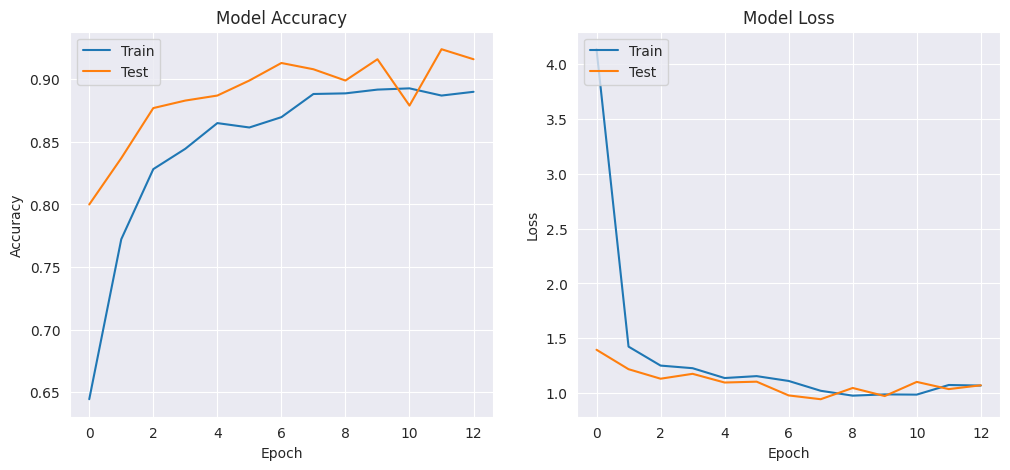

In [32]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

El modelo muestra una alta precisión, mejorando rápidamente en las primeras épocas y alcanzando valores superiores al 90% tanto en el conjunto de entrenamiento como en el de validación y baja pérdida; e indica un buen rendimiento y capacidad de generalización.

Con respecto a la pérdida, disminuye mucho en las primeras épocas y entorno a 1 se estabiliza.

In [33]:
# Evaluar el modelo en el conjunto de datos de prueba
test_loss, test_accuracy = model3.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


32/32 [==============================] - 3s 94ms/step - loss: 0.9459 - accuracy: 0.9080
Test Loss: 0.9459
Test Accuracy: 0.9080


## Comparación

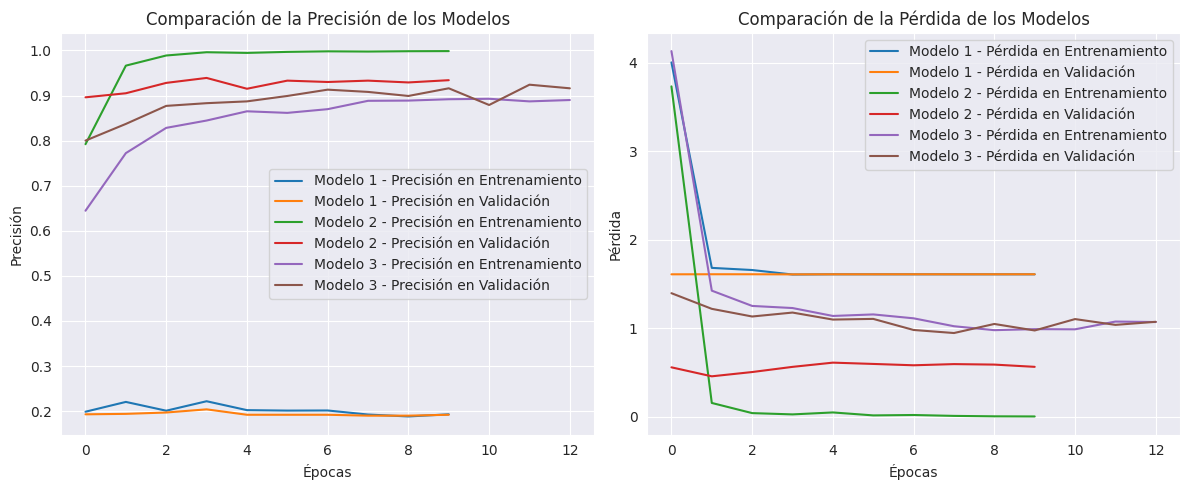

Modelo 1 - Pérdida: 1.6102252006530762, Precisión: 0.19200000166893005
Modelo 2 - Pérdida: 0.5636720061302185, Precisión: 0.9340000152587891
Modelo 3 - Pérdida: 0.9459360837936401, Precisión: 0.9079999923706055


In [35]:
def compare_models(history1, history2, history3, model1, model2, model3, X_test, y_test):
    # Comparar precisión
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['accuracy'], label='Modelo 1 - Precisión en Entrenamiento')
    plt.plot(history1.history['val_accuracy'], label='Modelo 1 - Precisión en Validación')
    plt.plot(history2.history['accuracy'], label='Modelo 2 - Precisión en Entrenamiento')
    plt.plot(history2.history['val_accuracy'], label='Modelo 2 - Precisión en Validación')
    plt.plot(history3.history['accuracy'], label='Modelo 3 - Precisión en Entrenamiento')
    plt.plot(history3.history['val_accuracy'], label='Modelo 3 - Precisión en Validación')
    plt.title('Comparación de la Precisión de los Modelos')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    # Comparar pérdida
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['loss'], label='Modelo 1 - Pérdida en Entrenamiento')
    plt.plot(history1.history['val_loss'], label='Modelo 1 - Pérdida en Validación')
    plt.plot(history2.history['loss'], label='Modelo 2 - Pérdida en Entrenamiento')
    plt.plot(history2.history['val_loss'], label='Modelo 2 - Pérdida en Validación')
    plt.plot(history3.history['loss'], label='Modelo 3 - Pérdida en Entrenamiento')
    plt.plot(history3.history['val_loss'], label='Modelo 3 - Pérdida en Validación')
    plt.title('Comparación de la Pérdida de los Modelos')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluación en el conjunto de prueba
    score1 = model1.evaluate(X_test, y_test, verbose=0)
    score2 = model2.evaluate(X_test, y_test, verbose=0)
    score3 = model3.evaluate(X_test, y_test, verbose=0)
    print(f"Modelo 1 - Pérdida: {score1[0]}, Precisión: {score1[1]}")
    print(f"Modelo 2 - Pérdida: {score2[0]}, Precisión: {score2[1]}")
    print(f"Modelo 3 - Pérdida: {score3[0]}, Precisión: {score3[1]}")

# Llamar a la función con los historiales de entrenamiento y modelos correspondientes
compare_models(history, history2, history3, model, model2, model3, X_test, y_test)


## **Predicción**

32/32 [==============================] - 4s 114ms/step


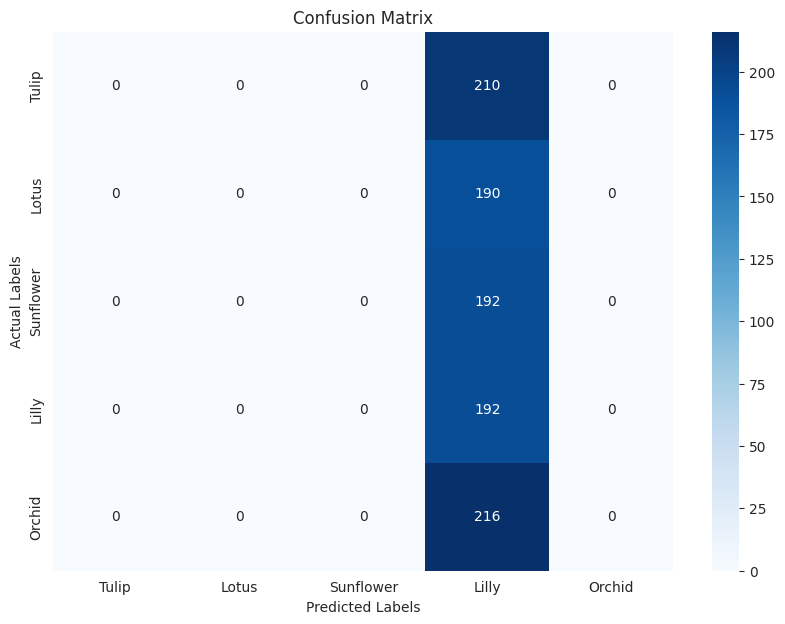

              precision    recall  f1-score   support

       Tulip       0.00      0.00      0.00       210
       Lotus       0.00      0.00      0.00       190
   Sunflower       0.00      0.00      0.00       192
       Lilly       0.19      1.00      0.32       192
      Orchid       0.00      0.00      0.00       216

    accuracy                           0.19      1000
   macro avg       0.04      0.20      0.06      1000
weighted avg       0.04      0.19      0.06      1000

  Actual Labels Predicted Labels
0         Lotus            Lilly
1         Lilly            Lilly
2         Lilly            Lilly
3         Lotus            Lilly
4        Orchid            Lilly


In [46]:
# Predicción en el conjunto de prueba modelo 1
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes)
cm_df = pd.DataFrame(cm,
                     index = [i for i in label_names],
                     columns = [i for i in label_names])

# Visualizar la matriz de confusión en un heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Informe de clasificación para ver la precisión por clase
print(classification_report(y_test, y_pred_classes, target_names=label_names))

# Crear una tabla para comparar las etiquetas reales con las predicciones
comparison_table = pd.DataFrame({'Actual Labels': y_test, 'Predicted Labels': y_pred_classes})
comparison_table.replace({'Actual Labels': dict(enumerate(label_names)), 'Predicted Labels': dict(enumerate(label_names))}, inplace=True)
print(comparison_table.head())

El modelo clasifica incorrectamente todas las clases como "Lilly", sin importar la etiqueta real. No se detectan otras clases (Tulip, Lotus, Sunflower, Orchid).

Esto indica, no solo que el modelo no es bueno para clasificar sino que está totalmente sesgado hacia la clase 'lilly'

32/32 [==============================] - 6s 92ms/step


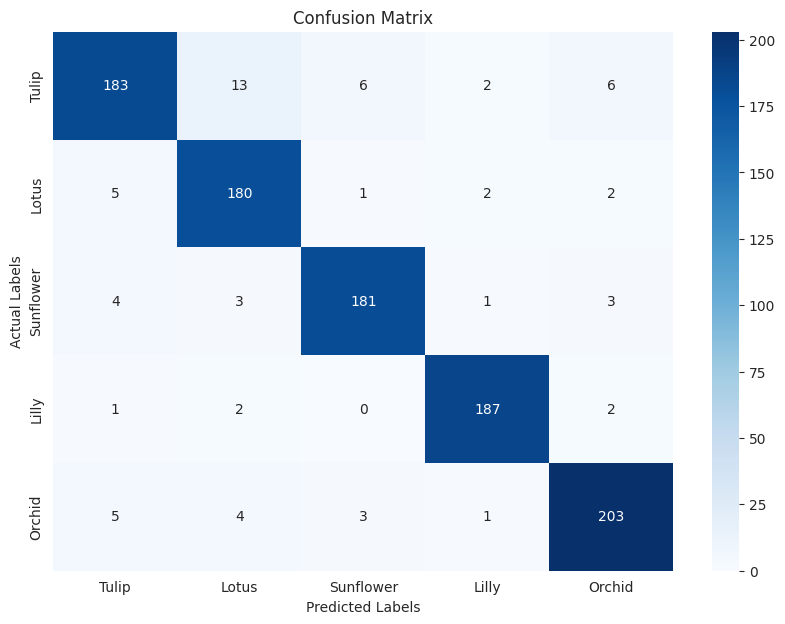

              precision    recall  f1-score   support

       Tulip       0.92      0.87      0.90       210
       Lotus       0.89      0.95      0.92       190
   Sunflower       0.95      0.94      0.95       192
       Lilly       0.97      0.97      0.97       192
      Orchid       0.94      0.94      0.94       216

    accuracy                           0.93      1000
   macro avg       0.93      0.94      0.93      1000
weighted avg       0.93      0.93      0.93      1000

  Actual Labels Predicted Labels
0         Lotus            Lotus
1         Lilly            Lilly
2         Lilly            Lilly
3         Lotus            Lotus
4        Orchid        Sunflower


In [47]:
# Predicción en el conjunto de prueba modelo 2
y_pred = model2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes)
cm_df = pd.DataFrame(cm,
                     index = [i for i in label_names],
                     columns = [i for i in label_names])

# Visualizar la matriz de confusión en un heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Informe de clasificación para ver la precisión por clase
print(classification_report(y_test, y_pred_classes, target_names=label_names))

# Crear una tabla para comparar las etiquetas reales con las predicciones
comparison_table = pd.DataFrame({'Actual Labels': y_test, 'Predicted Labels': y_pred_classes})
comparison_table.replace({'Actual Labels': dict(enumerate(label_names)), 'Predicted Labels': dict(enumerate(label_names))}, inplace=True)
print(comparison_table.head())

El modelo muestra una buena capacidad para clasificar correctamente las diferentes clases:

- Tulip: 183 clasificaciones correctas, 27 incorrectas.
- Lotus: 180 clasificaciones correctas, 10 incorrectas.
- Sunflower: 181 clasificaciones correctas, 11 incorrectas.
- Lilly: 187 clasificaciones correctas, 5 incorrectas.
- Orchid: 203 clasificaciones correctas, 13 incorrectas.

En cuanto a métricas y precisión, muestran que es un buen modelo para clasificación ya que:

- Las métricas son altas para todas las clases, con valores de precisión y recall superiores al 89% y F1-score superiores al 90%.
- La exactitud del modelo es del 93%, lo que indica un buen rendimiento global.

32/32 [==============================] - 5s 97ms/step


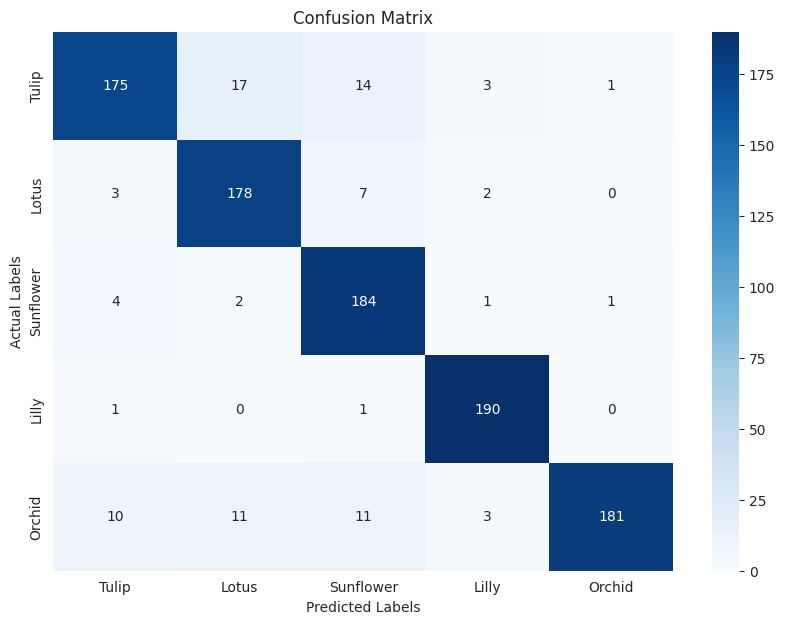

              precision    recall  f1-score   support

       Tulip       0.91      0.83      0.87       210
       Lotus       0.86      0.94      0.89       190
   Sunflower       0.85      0.96      0.90       192
       Lilly       0.95      0.99      0.97       192
      Orchid       0.99      0.84      0.91       216

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000

  Actual Labels Predicted Labels
0         Lotus            Lotus
1         Lilly            Lilly
2         Lilly            Lilly
3         Lotus            Lotus
4        Orchid        Sunflower


In [48]:
# Predicción en el conjunto de prueba modelo 3
y_pred = model3.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes)
cm_df = pd.DataFrame(cm,
                     index = [i for i in label_names],
                     columns = [i for i in label_names])

# Visualizar la matriz de confusión en un heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Informe de clasificación para ver la precisión por clase
print(classification_report(y_test, y_pred_classes, target_names=label_names))

# Crear una tabla para comparar las etiquetas reales con las predicciones
comparison_table = pd.DataFrame({'Actual Labels': y_test, 'Predicted Labels': y_pred_classes})
comparison_table.replace({'Actual Labels': dict(enumerate(label_names)), 'Predicted Labels': dict(enumerate(label_names))}, inplace=True)
print(comparison_table.head())

Lo mismo sucede en el modelo 3, aunque hay una leve bajada de verdaderos positivos y negativos:

El modelo muestra un buen desempeño al clasificar las diferentes clases:

- Tulip: 175 clasificaciones correctas, 35 incorrectas.
- Lotus: 178 clasificaciones correctas, 12 incorrectas.
- Sunflower: 184 clasificaciones correctas, 8 incorrectas.
-Lilly: 190 clasificaciones correctas, 2 incorrectas.
- Orchid: 181 clasificaciones correctas, 35 incorrectas.

En cuanto a métricas y precisión, muestran que es un buen modelo para clasificación a pesar que hayan disminuido los valores con respecto al modelo 2.

Por ello, para realizar la predicción y clasificación de una nueva imagen fuera del set de datos, se va a escoger el modelo 2 ya que ha sido el que mejores resultados se han obtenido.

Primero se procesa la imagen a utilizar

In [58]:
def prepare_image(image_path):
    try:
        img = load_img(image_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Agrega la dimensión del batch
        img_array = preprocess_input(img_array)  # Asegúrate de que esto coincide con cómo tu modelo fue entrenado
        return img_array
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

Luego, se quiere determinar la clase de la imagen y a su vez devolver la etiqueta predicha y la probabilidad de la predicción más probable.

In [59]:
def predict_with_prob(image_path, model, class_labels):
    """Determina la clase de la imagen y devuelve la etiqueta y probabilidad de la predicción más probable."""
    img = prepare_image(image_path)
    if img is not None:
        predictions = model.predict(img)
        class_index = np.argmax(predictions, axis=1)[0]
        probability = np.max(predictions, axis=1)[0]
        return (class_labels[class_index], probability)
    else:
        return ("La imagen no se encontró o no pudo leerse", None)

# Lista de etiquetas de clase
class_labels = ['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']  # Asegúrate de que estas etiquetas estén en el orden correcto

# Uso de la función
image_path = '/content/PRUEBA ORQUIDEA.jpg'
label, prob = predict_with_prob(image_path, model2, class_labels)
print(f"Predicción: {label}, Probabilidad: {prob:.4f}")

1/1 [==============================] - 0s 44ms/step
Predicción: Orchid, Probabilidad: 1.0000


In [60]:
image_path = '/content/PRUEBA TULIPAN.jpg'
label, prob = predict_with_prob(image_path, model2, class_labels)
print(f"Predicción: {label}, Probabilidad: {prob:.4f}")

1/1 [==============================] - 0s 36ms/step
Predicción: Tulip, Probabilidad: 1.0000


In [61]:
image_path = '/content/PRUEBA-GIRASOL.jpg'
label, prob = predict_with_prob(image_path, model2, class_labels)
print(f"Predicción: {label}, Probabilidad: {prob:.4f}")

1/1 [==============================] - 0s 36ms/step
Predicción: Sunflower, Probabilidad: 1.0000


En estos casos, se observa que en las tres imágenes utilizadas hay una probabilidad muy alta de que correspondan a la imagen aportada.

En conclusión, el modelo 2 demuestra una alta confianza en sus predicciones, asignando una probabilidad de 1.0000 a cada clase en estas imágenes de prueba. Esto sugiere que el modelo está muy seguro de sus clasificaciones para estas muestras específicas.